# Previsão de Inadimplência com ML

# 1. Descrição do Problema

Modelos de score de crédito calculam a probabilidade de inadimplência e são uma das
principais ferramentas utilizadas por diversas empresas para aprovar ou negar um
crédito.
O objetivo deste desafio é criar um modelo preditivo calculando a probabilidade de
inadimplência de cada novo pedido de crédito.

In [110]:
import pandas as pd
import numpy as np

# 2. O Dataset

In [111]:
dtf = pd.read_csv("treino.csv")
dtf.head()

inadimplente  util_linhas_inseguras  idade  vezes_passou_de_30_59_dias  \
0             1               0.766127     45                           2   
1             0               0.957151     40                           0   
2             0               0.658180     38                           1   
3             0               0.233810     30                           0   
4             0               0.907239     49                           1   

   razao_debito  salario_mensal  numero_linhas_crdto_aberto  \
0      0.802982          9120.0                          13   
1      0.121876          2600.0                           4   
2      0.085113          3042.0                           2   
3      0.036050          3300.0                           5   
4      0.024926         63588.0                           7   

   numero_vezes_passou_90_dias  numero_emprestimos_imobiliarios  \
0                            0                                6   
1                            0                                0   
2                            1                                0   
3                            0                                0   
4                            0                                1   

   numero_de_vezes_que_passou_60_89_dias  numero_de_dependentes  
0                                      0                    2.0  
1                                      0                    1.0  
2                                      0                    0.0  
3                                      0                    0.0  
4                                      0                    0.0

# 3. Análise Exploratória

In [3]:
from pandas_profiling import ProfileReport
ProfileReport(dtf)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 4. Preparo das Features

## 4.1 Lidando com NaNs

In [112]:
dtf = dtf.dropna()

## 4.2 Outliers

### 4.2.1 Util_Linhas_Inseguras

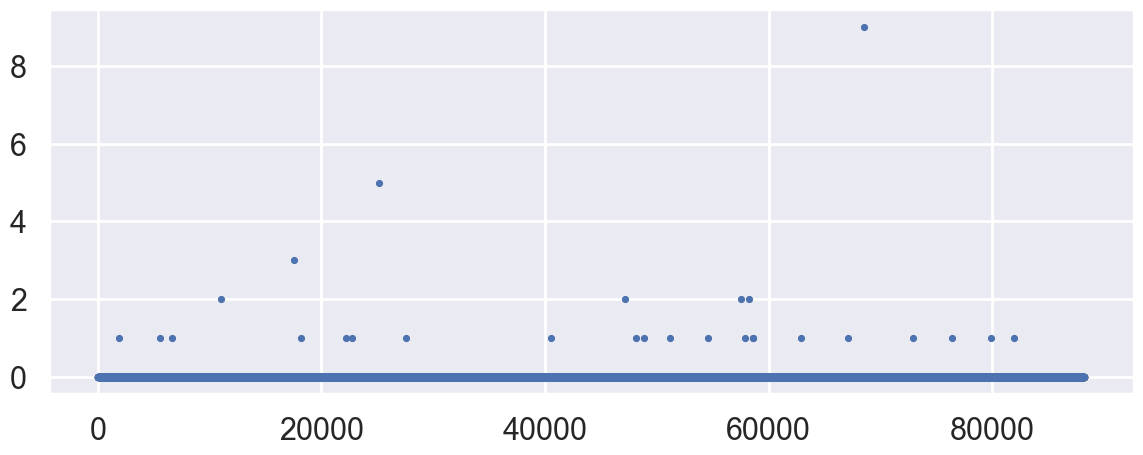

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_context('poster',font_scale = 1)
plt.figure(figsize = (14,5))
bins = pd.cut(dtf.util_linhas_inseguras,10,labels = False)
plt.scatter(y = bins,x = range(bins.size),s = 10)
plt.show()

In [267]:
dtf.util_linhas_inseguras[dtf.util_linhas_inseguras > 1] = dtf.util_linhas_inseguras.median()

C:\Users\nicho\AppData\Local\Temp\ipykernel_1868\1970981123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf.util_linhas_inseguras[dtf.util_linhas_inseguras > 1] = dtf.util_linhas_inseguras.median()


### 4.2.2 Razao_Debito

In [268]:
dtf['razao_debito'].describe()

count     40000.000000
mean        348.004166
std        1934.436246
min           0.000000
25%           0.175360
50%           0.366172
75%           0.872253
max      307001.000000
Name: razao_debito, dtype: float64

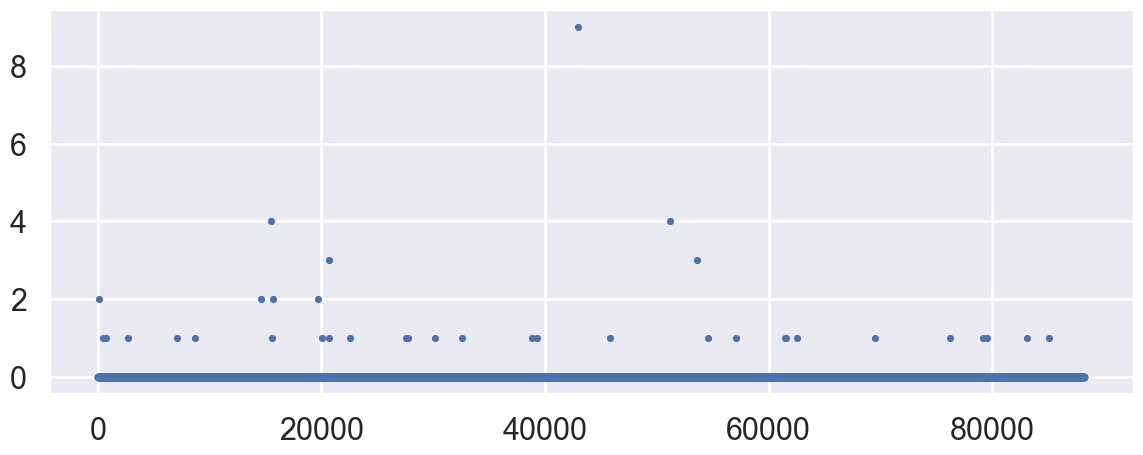

In [116]:
sns.set_context('poster',font_scale = 1)
plt.figure(figsize = (14,5))
bins = pd.cut(dtf['razao_debito'],10,labels = False)
plt.scatter(y = bins,x = range(bins.size),s = 10)
plt.show()

In [269]:
dtf.razao_debito[dtf.razao_debito > 1] = dtf.razao_debito.median()

C:\Users\nicho\AppData\Local\Temp\ipykernel_1868\3636389538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf.razao_debito[dtf.razao_debito > 1] = dtf.razao_debito.median()


### 4.2.3 Salario_Mensal

In [118]:
dtf.salario_mensal.describe()

count    8.823700e+04
mean     6.637411e+03
std      1.338395e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.225000e+03
max      3.008750e+06
Name: salario_mensal, dtype: float64

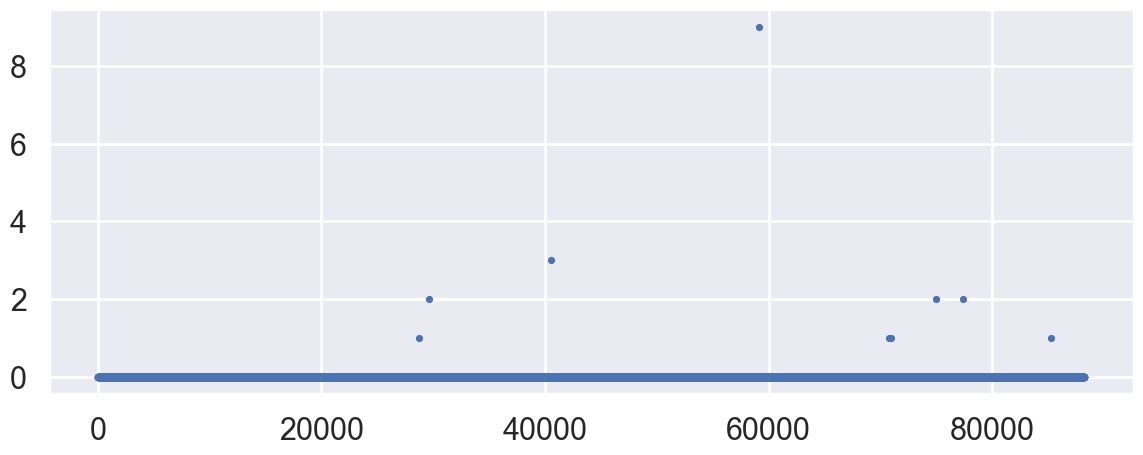

In [119]:
sns.set_context('poster',font_scale = 1)
plt.figure(figsize = (14,5))
bins = pd.cut(dtf.salario_mensal,10,labels = False)
plt.scatter(y = bins,x = range(bins.size),s = 10)
plt.show()

In [270]:
from scipy import stats
dtf.salario_mensal[abs(stats.zscore(dtf.salario_mensal)) > 3] = dtf.salario_mensal.median()

C:\Users\nicho\AppData\Local\Temp\ipykernel_1868\1827926715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf.salario_mensal[abs(stats.zscore(dtf.salario_mensal)) > 3] = dtf.salario_mensal.median()


## 4.3 Feature Engineering

In [271]:
# Transforma a idade em intervalos regulares
from sklearn.preprocessing import LabelEncoder
dtf['idade'] = pd.cut(dtf.idade,10)
le = LabelEncoder()
dtf['idade'] = le.fit_transform(dtf.idade)

In [272]:
# Cria uma nova feature salario/numero de dependentes
dtf['salario_por_dependentes'] = (dtf.salario_mensal/dtf.numero_de_dependentes).replace(np.inf,0).fillna(0)

In [273]:
# Cria nova feature somando-se todos os atrasos
dtf['atrasos'] = dtf.vezes_passou_de_30_59_dias + dtf.numero_de_vezes_que_passou_60_89_dias + dtf.numero_vezes_passou_90_dias

In [274]:
# Atrasos^2
dtf['atrasos_sq'] = dtf['atrasos']**2

In [275]:
# Novas features que representam o log de salário mensal, numero_emprestimos_imobiliarios e numero_linhas_crdto_aberto
dtf['numero_emprestimos_imobiliarios_log'] = np.log(dtf['numero_emprestimos_imobiliarios']).replace([-np.inf,np.inf],0)
dtf['numero_linhas_crdto_aberto_log'] = np.log(dtf['numero_linhas_crdto_aberto']).replace([np.inf,-np.inf],0)
dtf['salario_mensal_log'] = np.log(dtf.salario_mensal).replace([np.inf,-np.inf],0)

C:\Users\nicho\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nicho\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nicho\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [276]:
# Nova feature que representa os atrasos com peso exponencial
dtf['atrasos2'] = dtf.vezes_passou_de_30_59_dias + dtf.numero_de_vezes_que_passou_60_89_dias**2 + dtf.numero_vezes_passou_90_dias ** 3

## 4.4 Feature Selection

In [277]:
features = ['idade',
            'salario_mensal',
            'vezes_passou_de_30_59_dias',
            'numero_de_vezes_que_passou_60_89_dias',
            'numero_vezes_passou_90_dias',
            'util_linhas_inseguras',
            'razao_debito',
            'numero_linhas_crdto_aberto',
            'numero_emprestimos_imobiliarios',
            'numero_de_dependentes',
            'salario_por_dependentes',
            'atrasos',
            'atrasos_sq',
            'numero_emprestimos_imobiliarios_log',
            'numero_linhas_crdto_aberto_log',
            'salario_mensal_log',
            'atrasos2'
           ]

In [128]:
X = dtf[features]
y = dtf.inadimplente.values

## 4.5 Normalização os dados

In [129]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 4.6 Train/Test

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## 4.7 Oversampling

Realizamos o oversampling do target inadimplência

In [131]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
oversample = RandomOverSampler(sampling_strategy=0.1,random_state=1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

# 5. Avaliação dos Modelos

Para facilitar a avaliação dos modelos foram criadas 2 funções

In [149]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

results = {}

def test_model(model,X_train,X_test,y_train,y_test,model_name):
    y_pred = model.predict(X_test)
    TN,FP = confusion_matrix(y_pred,y_test)[0]
    FN,TP = confusion_matrix(y_pred,y_test)[1]
    Recall = round(TP/(TP+FN),2)
    Precision = round(TP/(TP+FP),2)
    AUC_ROC = round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),3)
    print(f"\nTest AUC ROC: {AUC_ROC}\nRecall:{Recall}\nPrecision:{Precision}")
    plot_confusion_matrix(conf_mat=confusion_matrix(y_pred,y_test),show_absolute=True,show_normed=True)
    results[model_name] = {
        'Auc_roc':round(AUC_ROC,3),
        'Recall':Recall,
        'Precision':Precision
    }

def test_model_neural_net(model,X_train,X_test,y_train,y_test):
    y_pred = model.predict(X_test)
    y_pred = [1 if v > 0.5 else 0for v in y_pred]
    TN,FP = confusion_matrix(y_pred,y_test)[0]
    FN,TP = confusion_matrix(y_pred,y_test)[1]
    Recall = round(TP/(TP+FN),2)
    Precision = round(TP/(TP+FP),2)
    print(f"Test AUC ROC: {roc_auc_score(y_test, y_pred)}\nRecall:{Recall}\nPrecision:{Precision}")
    plot_confusion_matrix(conf_mat=confusion_matrix(y_pred,y_test),show_absolute=False,show_normed=True)
    results['NeuralNet'] = {
        'Auc_roc':roc_auc_score(y_test, y_pred),
        'Recall':Recall,
        'Precision':Precision
    }
    
sns.reset_orig()

## 5.1. Logistic Regression


Test AUC ROC: 0.836
Recall:0.54
Precision:0.18


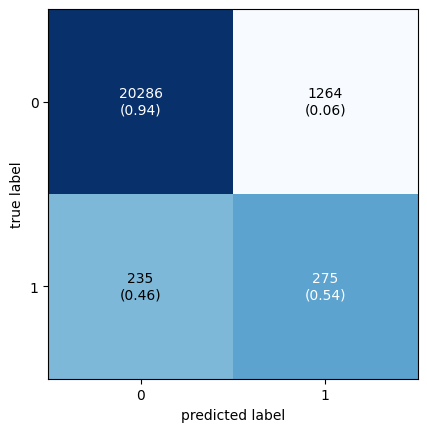

In [133]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=200).fit(X_train, y_train,)
test_model(model,X_train,X_test,y_train,y_test,"LogisticRegression")

## 5.2 KNN


Test AUC ROC: 0.743
Recall:0.55
Precision:0.04


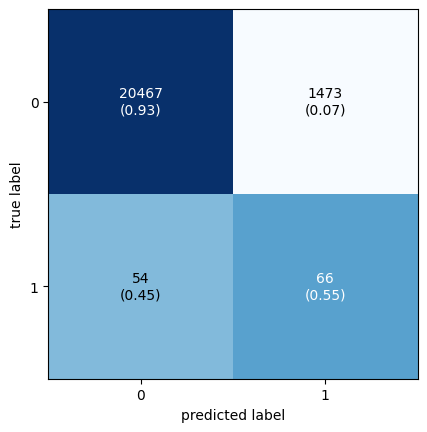

In [134]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(25).fit(X_train, y_train)
test_model(model,X_train,X_test,y_train,y_test,"KNN")

## 5.3. Naive Bayes


Test AUC ROC: 0.815
Recall:0.31
Precision:0.52


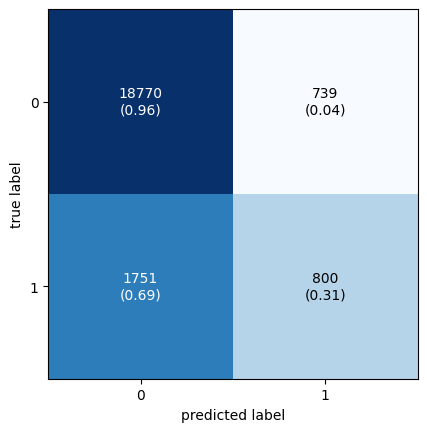

In [135]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train, y_train)
test_model(model,X_train,X_test,y_train,y_test,"NaiveBayes")

## 5.4. Decision Tree


Test AUC ROC: 0.604
Recall:0.25
Precision:0.27


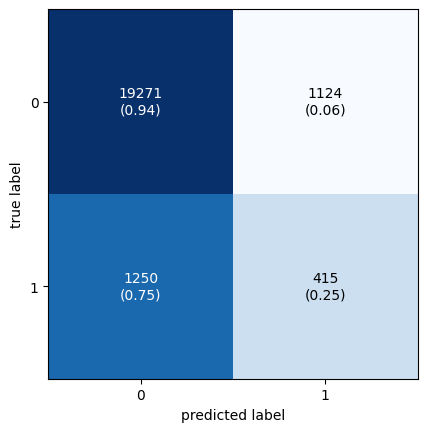

In [136]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier().fit(X_train, y_train)
test_model(model,X_train,X_test,y_train,y_test,"DecisionTree")

## 5.5. Random Forest


Test AUC ROC: 0.823
Recall:0.48
Precision:0.18


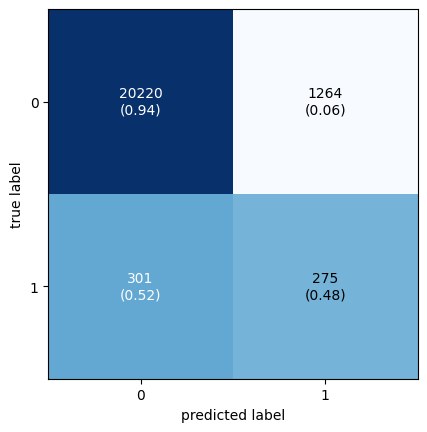

In [137]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(X_train, y_train)
test_model(model,X_train,X_test,y_train,y_test,"RandomForest")

## 5.6. XGBoost

In [138]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV

params={
 "learning_rate"    : [0.0005, 0.001, 0.01, 0.05, 0.10, 0.15, 0.20,] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 30, 35, 40],
 "min_child_weight" : [ 1, 3, 5, 7, 10],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators"     : [50, 100, 200, 400, 500]
}

In [ ]:
model = xgboost.XGBClassifier()
random_search=RandomizedSearchCV(model,
                                 param_distributions=params,
                                 n_iter=50,
                                 scoring='roc_auc',
                                 n_jobs=-1,
                                 cv=5,
                                 verbose=3)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [403]:
model = random_search.best_estimator_
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=30, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [255]:
model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=30, max_leaves=0, min_child_weight=3,
              monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)


Test AUC ROC: 0.821
Recall:0.49
Precision:0.18


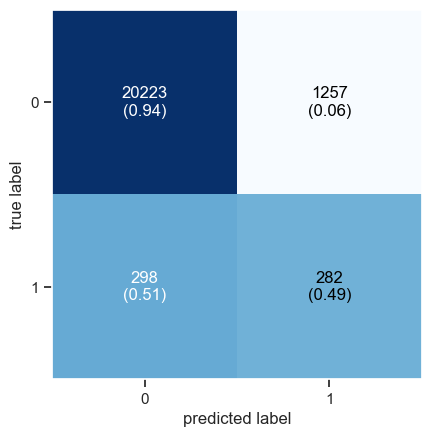

In [256]:
model.fit(X_train,y_train)
test_model(model,X_train,X_test,y_train,y_test,"XGBoost")

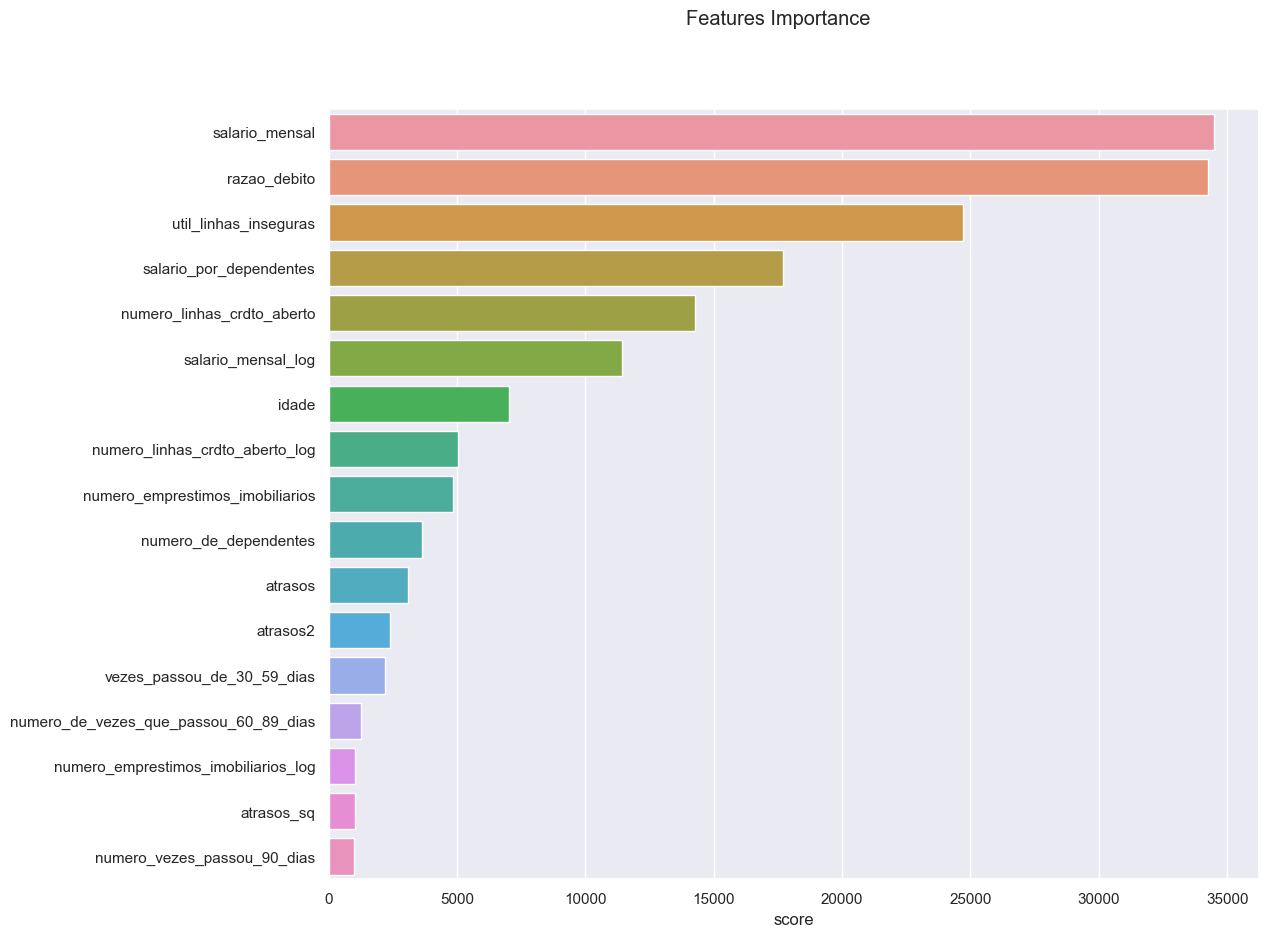

In [257]:
import matplotlib.pyplot as plt
import seaborn as sns
features_importance = model.get_booster().get_score(importance_type='weight')
feature_names = dict(zip(features_importance.keys(),scaler.get_feature_names_out()))
data = pd.DataFrame(data=features_importance.values(), index=features_importance.keys(), columns=["score"]).sort_values(by = "score", ascending=False)

fig = plt.figure(figsize = (12,10))
fig.suptitle('Features Importance')
sns.barplot(x = data.score,y = data.index.map(feature_names))
plt.show()

## 5.7. Neural Net

Epoch 1/20
14/14 [==============================] - 1s 11ms/step - loss: 0.6087 - auc_4: 0.5314
Epoch 2/20
14/14 [==============================] - 0s 10ms/step - loss: 0.3470 - auc_4: 0.6061
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 0.2889 - auc_4: 0.7066
Epoch 4/20
14/14 [==============================] - 0s 10ms/step - loss: 0.2729 - auc_4: 0.7557
Epoch 5/20
14/14 [==============================] - 0s 11ms/step - loss: 0.2603 - auc_4: 0.7773
Epoch 6/20
14/14 [==============================] - 0s 10ms/step - loss: 0.2502 - auc_4: 0.7961
Epoch 7/20
14/14 [==============================] - 0s 10ms/step - loss: 0.2460 - auc_4: 0.8042
Epoch 8/20
14/14 [==============================] - 0s 10ms/step - loss: 0.2418 - auc_4: 0.8135
Epoch 9/20
14/14 [==============================] - 0s 10ms/step - loss: 0.2393 - auc_4: 0.8188
Epoch 10/20
14/14 [==============================] - 0s 11ms/step - loss: 0.2392 - auc_4: 0.8197
Epoch 11/20
14/14 [====================

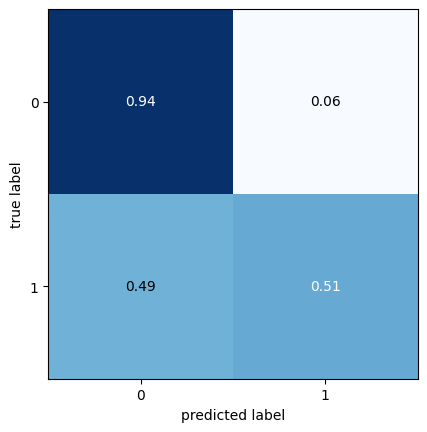

In [153]:
import tensorflow as tf
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100,"tanh"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(50,"relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10,"relu"))
model.add(tf.keras.layers.Dense(1,"sigmoid"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),loss="binary_crossentropy",metrics=tf.keras.metrics.AUC())

model.fit(X_train, y_train, batch_size = 5000, epochs = 20)

test_model_neural_net(model,X_train,X_test,y_train,y_test)

# 6. Conclusão

In [180]:
data = pd.DataFrame(results).T.reset_index()
data = data.rename(columns={'index':"Modelo"})
data = data.melt(id_vars=['Modelo'])

Modelo  Auc_roc  Recall  Precision
0  LogisticRegression    0.836    0.54       0.18
1                 KNN    0.743    0.55       0.04
2          NaiveBayes    0.815    0.31       0.52
3        DecisionTree    0.604    0.25       0.27
4        RandomForest    0.823    0.48       0.18
5             XGBoost    0.821    0.49       0.18
6           NeuralNet    0.595    0.51       0.20

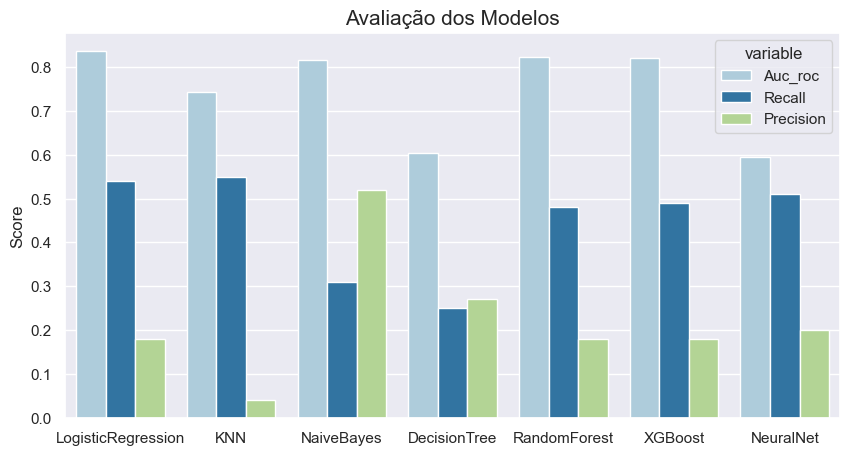

In [253]:
sns.set()
plt.figure(figsize=(10,5))
sns.barplot(x="Modelo",y="value",hue="variable",data=data,palette=sns.color_palette("Paired"))
plt.title('Avaliação dos Modelos',fontsize = 15)
plt.xlabel('')
plt.ylabel('Score')
plt.show()

O modelo que apresentou o melhor score foi a Regressão Logística.

# 7. Submit do conjunto de teste

In [262]:
dtf = pd.read_csv("teste.csv")

In [289]:
dtf.isna().sum()

util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
salario_por_dependentes                  0
atrasos                                  0
atrasos_sq                               0
numero_emprestimos_imobiliarios_log      0
numero_linhas_crdto_aberto_log           0
salario_mensal_log                       0
atrasos2                                 0
dtype: int64

In [285]:
mediana_salario_mensal = dtf.salario_mensal.median()
mediana_numero_de_dependentes = dtf.numero_de_dependentes.median()
mediana_salario_mensal_log = dtf.salario_mensal_log.median()

dtf['salario_mensal'].fillna(mediana_salario_mensal,inplace=True)
dtf['numero_de_dependentes'].fillna(mediana_numero_de_dependentes,inplace=True)
dtf['salario_mensal_log'].fillna(mediana_salario_mensal_log,inplace=True)

In [307]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
oversample = RandomOverSampler(sampling_strategy=0.1,random_state=1)
X_os, y_os = oversample.fit_resample(X, y)

In [308]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=200).fit(X_os, y_os)

In [309]:
X_test = dtf[features]
X_test = scaler.transform(X_test)
y_test = model.predict(X_test)

In [315]:
sum(y_test == 1)/len(y_test)

0.027725

In [318]:
dtf['inadimplente'] = y_test

In [321]:
dtf.inadimplente.value_counts()

0    38891
1     1109
Name: inadimplente, dtype: int64

In [323]:
dtf.to_csv("predicted.csv")